2024-09-17 - Ronen Shekel

In [39]:
%matplotlib ipympl
import glob, os, sys, datetime
import numpy as np
import matplotlib.pyplot as plt
from pianoq_results.scan_result import ScanResult
from pianoq_results.misc import my_mesh
from pianoq.misc.misc import detect_gaussian_spots_subpixel
from pianoq.misc.mplt import mimshow
from pianoq.simulations.mplc_sim.mplc_sim_result import MPLCSimResult
from matplotlib.patches import Rectangle
dir_path = r'G:\My Drive\Projects\MPLC\results\lab\2024_09_17_first_diffuser'
d_no = 1 

# Goals 
We want to get to a place where we are able to perform the scaling experiment. For this, we want to:
- understand where exactly my diffusers send the light in comparison to simulation with WFM 
- see the amount of counts we have in the two-photon measurements 
- get an even better understanding of the correction phase on plane 1:
    - do opposite phases on correlated modes really cancel out? 
    - try and measure cleverly the correction phases 
    - These phases will probably be already in a future writeup

# Single counts
I performed rough large scans to see where the photons actually hit in both detectors. At the top of the signal scan you see the edge of the idler, and in the bottom of the idler scan you see the edge of the signal. In red I show an area of the size of half a mask (upper or lower for signal or idler). 

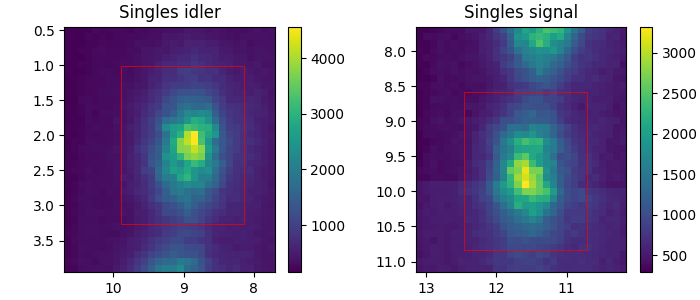

In [79]:
singles_sig_path = glob.glob(rf'{dir_path}\*singles_signal*.scan')[0]
singles_idl_path = glob.glob(rf'{dir_path}\*singles_idler*.scan')[0]
s_sig = ScanResult()
s_sig.loadfrom(singles_sig_path)
s_idl = ScanResult()
s_idl.loadfrom(singles_idl_path)

fig, axes = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
my_mesh(s_idl.X, s_idl.Y, s_idl.single1s, axes[0])
axes[0].invert_xaxis()
axes[0].set_title('Singles idler')

my_mesh(s_sig.X, s_sig.Y, s_sig.single2s, axes[1])
axes[1].invert_xaxis()
axes[1].set_title('Singles signal')

x_start_idl = 9.02 - 70*12.5e-3
y_start_idl = 2.14 - 90*12.5e-3
# axes[0].add_patch(Rectangle((8.1, 1.1), 12.5e-3*140, 12.5e-3*180, facecolor="none", ec='g', lw=0.5))
axes[0].add_patch(Rectangle((x_start_idl, y_start_idl), 12.5e-3*140, 12.5e-3*180, facecolor="none", ec='r', lw=0.5))

x_start_sig = 11.58 - 70*12.5e-3
y_start_sig = 9.71 - 90*12.5e-3
# axes[1].add_patch(Rectangle((10.7, 8.7), 12.5e-3*140, 12.5e-3*180, facecolor="none", ec='g', lw=0.5))
axes[1].add_patch(Rectangle((x_start_sig, y_start_sig), 12.5e-3*140, 12.5e-3*180, facecolor="none", ec='r', lw=0.5))

This seems pretty much OK. The photons don't mix too much with each other, and they seem to be scattered in roughly the planned area. For comparison, this is the expected incoherent some of the different speckle counts in the WFM design (originating only from 4 spots each blob):

Text(0.5, 1.0, 'incoherent speckles sum')

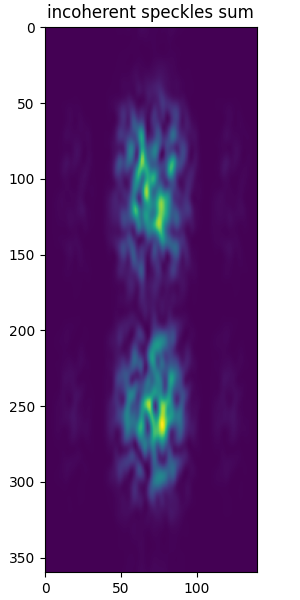

In [41]:
sim_res_path = glob.glob(rf'{dir_path}\*diffuser*d{d_no}d*.mplcsim')[0]
sr = MPLCSimResult()
sr.loadfrom(sim_res_path)
output_speckle_modes = np.arange(0, 8)
all_speckles = sr.backward_fields[-1, output_speckle_modes]
fig, ax = plt.subplots(figsize=(3, 6), constrained_layout=True)
ax.imshow((np.abs(all_speckles)**2).sum(axis=0)[sr.active_slice])
ax.set_title('incoherent speckles sum')

# mimshow((np.abs(all_speckles[0])**2)[sr.active_slice])

The original spread is narrower. But the original design was not for the outermost spots of the 25, and also maybe the convolution with the 100um fiber spreads it out a little bit in the measurement.

## calibration of mask location and motors 

It's actually a good idea to know exactly where these red rectangles should be, so let's look at a random transformation from before, and compare the motor location at a spot and the simulation location. 

I thought this might be easier if I use MPLC lenses to image the spots to plane 11, but to do that it demagnifies the spot, which defeats the purpose... I also couldn't measure them well, because the fiber was to big compared to the spot spacing. 

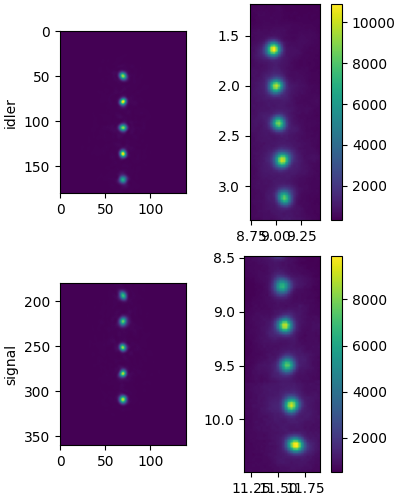

In [60]:
sim_path = glob.glob(rf'{dir_path}\Calibration\*.mplcsim')[0]
sim = MPLCSimResult()
sim.loadfrom(sim_path)
sim_spots = (np.abs(sim.forward_fields[-1])**2).sum(axis=0)[sim.active_slice]

sig_path = glob.glob(rf'{dir_path}\Calibration\*signal*.scan')[0]
sig_scan = ScanResult()
sig_scan.loadfrom(sig_path)

idl_path = glob.glob(rf'{dir_path}\Calibration\*idler*.scan')[0]
idl_scan = ScanResult()
idl_scan.loadfrom(idl_path)


fig, axes = plt.subplots(2, 2, figsize=(4, 5), constrained_layout=True)
axes[0, 0].imshow(sim_spots)
axes[0, 0].set_ylim([180, 0])
axes[1, 0].set_ylabel('signal')
axes[0, 0].set_ylabel('idler')

axes[1, 0].imshow(sim_spots)
axes[1, 0].set_ylim([360, 180])
my_mesh(idl_scan.X, idl_scan.Y, idl_scan.single1s, axes[0, 1])
my_mesh(sig_scan.X, sig_scan.Y, sig_scan.single2s, axes[1, 1])

Basically all simulated spots are at x=70, so the spots middle is the middle of the mask. In the experiment they become a bit crooked, so we will take the middle. so: `X_mid_idl = 9.02; X_mid_sig = 11.58`

In between the second and third outermost spots is the center, so:
`Y_mid_idl = 2.14; Y_mid_sig = 9.71`. 

This is not really so interesting, but I guess it is important so from now on I know what is the full scan range of a full plane 11. 

# Coincidences

So now I wanted to measure two-photon speckle. I have terrible SNR, so I needed to use integration time of 60s. 

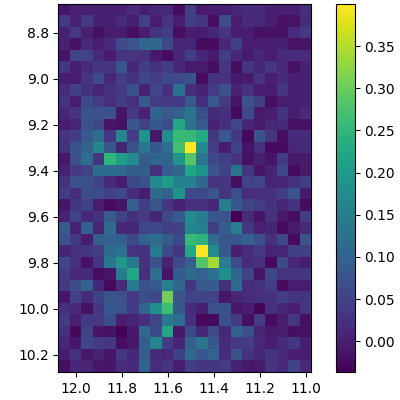

In [66]:
sc_path = glob.glob(rf'{dir_path}\*two_ph*60s*.scan')[0]
r = ScanResult()
r.loadfrom(sc_path)
fig, ax = plt.subplots(constrained_layout=True, figsize=(4, 4))
my_mesh(r.X, r.Y, r.real_coins, ax)
ax.invert_xaxis()

I can barely see a speckle pattern, but it is there... Does this amount of counts make sense? Lets think of the previous experiment, where we sent only 5 modes (discarded the rest), and had strong diagonal correlations at the end. Since we stayed in the 5-mode subspace pretty well, I think the 5/25 modes difference shouldn't make a difference to the expected amount of single counts. In practice I actually had more single counts in that experiemtn (7000-8000) compared to now (3000-4000). This actually makes sense, since the 5 spots went to five spots, but here the 25 spots also fill the gaps between the spots, so it makes sense that it will lower ~2X the counts, since we fill ~2X space. 

Regarding the correlations: the strongest correlation on the diagonal was ~5-10 counts/s. Assuming the correlations were perfect, out of the 8000 single counts on D1, we had 5-10 clicks on D2. Now we have half on D1, so we should expect 2-5 clicks on D2. But these are now smeared all over the speckle pattern. Considering a speckle grain is ~100um the whole mask has ~20X20 grains. We don't fill the whole mask etc., say 10X10, so we would expect mean counts of 0.02-0.05. Indeed we get mean counts of ~0.05, and the same std, as expected from a speckle pattern.

The total number of coins here is a bit tricky, since we scan here 50um with a 100um fiber. I am pretty sure it translates to a 4X effect. The mean should not be affected at all, and I think that also the std shouldn't: Say I took 4 different scans, each one of them is now fair, and will have some std. I just take them all together! The sum of real counts divided by 4 gives ~8, which is a bit higher than the expected 2-5. 

In [80]:
print(rf'{r.real_coins.mean()=:.3f}; {r.real_coins.std()=:.3f}')
print(rf'{r.real_coins.sum()/4=:.3f};')

r.real_coins.mean()=0.045; r.real_coins.std()=0.060
r.real_coins.sum()/4=7.855;
